# Defining the gym environment for the pruning problem

In [ ]:
%tensorflow_version 1.x
!pip install stable-baselines[mpi]==2.10.0
!pip install keras-rl2

from gym import Env
from gym.spaces import Discrete,Box
import numpy as np
from typing import Optional
import random
import matplotlib.pyplot as plt

# model parameters

MAX_ALLOWED_WORKER = 10
BUDGET = 5000
PLANTS = 10000
WAGE = 35
PRODUCTIVITY = 700
HIRE_COST = 100
FIRE_COST = 0
PRUNE_LENGTH = 3
PRUNE_PROFIT = 3


action_size = (MAX_ALLOWED_WORKER + 1) * (MAX_ALLOWED_WORKER + 1)
input_shape = 3
alpha = 0.6
beta = 0.4


class FarmEnv(Env):
    def __init__(self):
        super().__init__()
        # state = (number of hired workers, remaining budget , remaining plants)
        self.state = np.array([0,BUDGET,PLANTS])
        self.action_space = Discrete((MAX_ALLOWED_WORKER + 1) * (MAX_ALLOWED_WORKER + 1))
        self.observation_space = Box(low = np.array([0,0,0]), high = np.array([+MAX_ALLOWED_WORKER, +BUDGET, +PLANTS]))
        self.prune_len = PRUNE_LENGTH

    def step(self, action):

        self.prune_len -= 1
        info = {}
        done = False

        mapping = tuple(np.ndindex((MAX_ALLOWED_WORKER + 1, MAX_ALLOWED_WORKER + 1)))
        new_action = mapping[action]

        current_employee = self.state[0]
        cost = BUDGET - self.state[1]
        pruned_plants = PLANTS - self.state[2]


        hired = new_action[0]
        fired = new_action[1]

        reward = 0.0

        if (current_employee + hired) > MAX_ALLOWED_WORKER:
            reward = -5000.0
            return self.state, reward, done, info
        else:
            current_employee += hired

        cost += (hired * HIRE_COST)
        cost += (current_employee * WAGE)
        cost += (fired * FIRE_COST)

        pruned_plants += current_employee * round(np.random.normal(PRODUCTIVITY, 1))

        if current_employee - fired < 0:
            reward = -5000.0
            return self.state, reward, done, info
        else:
            current_employee = current_employee - fired

        if cost > BUDGET:
            reward -= 5000.0
            done = True

        if pruned_plants >= PLANTS:
            reward += 5000.0
            done = True

        if self.prune_len <= 0:
            done = True

        reward += ((alpha * (pruned_plants * PRUNE_PROFIT)) - (beta * cost) )

        self.state = np.array([current_employee, BUDGET - cost, PLANTS - pruned_plants])
        # self.state = current_employee * (BUDGET - cost) * (PLANTS - pruned_plants)

        return self.state, reward, done, info

    def render(self):
        pass

    def reset(self):
        # self.state = np.asarray([random.randint(0, MAX_ALLOWED_WORKER), random.randint(0, BUDGET),
        #                           random.randint(0, PLANTS)])
        self.state = np.asarray([0,BUDGET,PLANTS])
        self.prune_len = PRUNE_LENGTH
        return self.state


TensorFlow 1.x selected.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 248 kB 5.4 MB/s 
  Attempting uninstall: stable-baselines
    Found existing installation: stable-baselines 2.2.1
    Uninstalling stable-baselines-2.2.1:
      Successfully uninstalled stable-baselines-2.2.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52 kB 684 kB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=6f47d053673b9d0695376e8a895f9c456fe1c7c2d8ae46832ca61bbc3beed78b
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
ERROR: pip's dependency resolver does not currently 

# Creating the environment

In [ ]:
env = FarmEnv()
actions = env.action_space.n
states = env.observation_space.shape

obs = env.reset()
print("The initial observation is {}".format(obs))

# Sample a random action from the entire action space
random_action = env.action_space.sample()


# # Take the action and get the new observation space
new_obs, reward, done, info = env.step(random_action)
print("The new observation is {}".format(new_obs))

The initial observation is [    0  5000 10000]
The new observation is [   0 4055 5100]


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


source: https://stable-baselines.readthedocs.io/en/master/guide/callbacks.html

In [ ]:
from stable_baselines.common.callbacks import BaseCallback

class SaveOnBestTrainingRewardCallback(BaseCallback):

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print("Num timesteps: {}".format(self.num_timesteps))
                print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(self.best_mean_reward, mean_reward))

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print("Saving new best model to {}".format(self.save_path))
                  self.model.save(self.save_path)

        return True

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Checking the gym envirnment and initializing log to track the reward. 

In [ ]:
from stable_baselines.common.env_checker import check_env
from stable_baselines import DQN, PPO2, A2C, ACKTR
import os
from stable_baselines.bench import Monitor

# making sure the environment is correct based on Gym definition. 
print(check_env(env, warn=True))

# traking rewards
log_dir = "tmp/"
os.makedirs(log_dir, exist_ok=True)
env = Monitor(env, log_dir)
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

None


# Training the model 
Source: https://stable-baselines.readthedocs.io/en/master/

In [ ]:
# Training the model
time_steps = 25000
model = DQN('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=time_steps)








Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








--------------------------------------
| % time spent exploring  | 82       |
| episodes                | 100      |
| mean 100 episode reward | 1.59e+04 |
| steps                   | 440      |
--------------------------------------
--------------------------------------
| % time spent exploring  | 65       |
| episodes                | 200      |
| mean 100 episode reward | 9.54e+03 |
| steps                   | 874      |
--------------------------------------
--------------------------------------
| % time spent exploring  | 39       |
| episodes                | 300      |
| mean 100 episode reward | 7.42e+03 |
| steps                   | 1543     |
--------------------------------------
--------------------------------------
| % time spent exp

# Testing the model

In [ ]:
obs = env.reset()
track_reward = []
n_steps = 20
for step in range(n_steps):
  action, _ = model.predict(obs, deterministic=True)
  print("Step {}".format(step + 1))
  print("Action: ", action)
  obs, reward, done, info = env.step(action)
  print('obs=', obs, 'reward=', reward, 'done=', done)

  if done:
    # Note that the VecEnv resets automatically
    # when a done signal is encountered
    print("Goal reached!", "reward=", reward)
    track_reward.append(reward)
    break

Step 1
Action:  110
obs= [  10 3650 3000] reward= 12060.0 done= False
Step 2
Action:  1
obs= [    9  3300 -4010] reward= 29538.0 done= True
Goal reached! reward= 29538.0


Functions to plot the rewards

In [ ]:
from stable_baselines import results_plotter
from stable_baselines.results_plotter import load_results, ts2xy

def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')
    
def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.show()


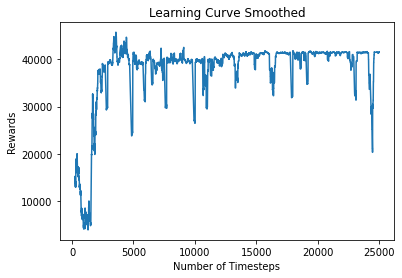

In [ ]:
plot_results(log_dir)

Code for mapping actions numbers to array. (Hire,Fire)

In [ ]:
mapping = tuple(np.ndindex((MAX_ALLOWED_WORKER + 1, MAX_ALLOWED_WORKER + 1)))

new_action = mapping[1]

print(new_action)

(0, 1)
